In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import floor, ceil


def boximage(box_width, box_height, width = 200, height = 200, center = None):
    if center is None:
        center = ((height-1)/2, (width-1)/2)


    im = np.zeros((height, width, 1), dtype=np.uint8)

    y_start = max(center[0]-box_height/2, 0)
    y_end = min(center[0]+box_height/2, height-1)

    x_start = max(center[1]-box_width/2, 0)
    x_end = min(center[1]+box_width/2, width-1)

    # Draw the edges
    im[floor(y_start), ceil(x_start):floor(x_end+1)] = 255*(ceil(y_start)-y_start)
    im[ceil(y_end), ceil(x_start):floor(x_end+1)] = 255*(y_end - floor(y_end))
    im[ceil(y_start):floor(y_end+1), floor(x_start)] = 255*(ceil(x_start) - x_start)
    im[ceil(y_start):floor(y_end+1), ceil(x_end)] = 255*(x_end - floor(x_end))

    # Draw the four corners
    im[floor(y_start), floor(x_start)] = 255*(ceil(y_start) - y_start)*(ceil(x_start) - x_start)
    im[floor(y_start), ceil(x_end)] = 255*(ceil(y_start) - y_start)*(x_end - floor(x_end))
    im[ceil(y_end), floor(x_start)] = 255*(y_end - floor(y_end))*(ceil(x_start) - x_start)
    im[ceil(y_end), ceil(x_end)] = 255*(y_end - floor(y_end))*(x_end - floor(x_end))

    # Fill the box
    im[ceil(y_start):floor(y_end+1), ceil(x_start):floor(x_end+1)] = 255


    return im

n_frames = 100
box_widths = np.linspace(0, 100, n_frames)
box_heights = np.linspace(10, 90, n_frames)
center_x = np.linspace(0, 200, n_frames)
center_y = np.linspace(0, 200, n_frames)
video = np.array([boximage(box_width, box_height, center = (cx, cy)) for box_width, box_height, cx, cy in zip(box_widths, box_heights, center_x, center_y)])

np.save('boxvideo.npy', video)

#animate video with matplotlib.funcanimation
def animate_video(video):
    %matplotlib tk

    fig, ax = plt.subplots(1, 1, figsize=(5, 10))

    def animate(frame):
        ax.clear()
        ax.imshow(video[frame], cmap='gray')
        ax.set_title(f'Frame {frame}')

    ani = animation.FuncAnimation(fig, animate, frames=range(len(video)), interval=5, repeat=False)

    return ani

#ani = animate_video(video)


In [3]:
from src.models.AE import Encoder, Decoder, AE
from src.utils.misc import load_config, animate_video
import torch

def build_model(model_type: str, CFG, device: str):
    H = CFG['data']['H']
    W = CFG['data']['W']
    latent_dim = CFG['AE']['D']
    if model_type == 'AutoEncoder':
        encoder = Encoder(H, W, latent_dim)
        decoder = Decoder(H, W, latent_dim)
        model = AE(encoder, decoder)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    return model



CFG = load_config('configs/config.yaml')
device = ('cuda' if torch.cuda.is_available() else 'cpu')
#model = build_model('AutoEncoder', CFG, device)
#model.load_state_dict(torch.load('data/model_weights/AutoEncoder_weights.pt', map_location=device))



# Perform frame interpolation


In [4]:
def interpolate_linear(observed_times, new_times, states):
    new_states = np.zeros((len(new_times), *states.shape[1:]))

    for j, time in enumerate(new_times):
        # find the two closest observed times
        idx = np.searchsorted(observed_times, time)
        if idx == 0:
            new_states[j] = states[0]
        elif idx == len(observed_times):
            new_states[j] = states[-1]
        else:
            # linearly interpolate between the two closest observed times
            alpha = (time - observed_times[idx-1]) / (observed_times[idx] - observed_times[idx-1])
            new_states[j] = alpha * states[idx] + (1 - alpha) * states[idx-1]

    return new_states


interpolated_video = interpolate_linear(np.arange(len(video)), np.arange(0, len(video), 0.1), video)

#ani = animate_video(interpolated_video)


# Train Autoencoder

In [5]:
from torch.utils.data import DataLoader
from src.training.trainer import Trainer

training_data = list(video.astype(np.float32))
train_loader = DataLoader(dataset=training_data, batch_size=CFG['training']['batch_size'], shuffle=True)

model = build_model('AutoEncoder', CFG, device)

trainer = Trainer(model, train_loader, config_path = 'configs/config.yaml', device = device)

In [6]:
losses = trainer.train()

Training: 100%|██████████| 800/800 [01:24<00:00,  9.50iter/s, Current loss=14.6]  


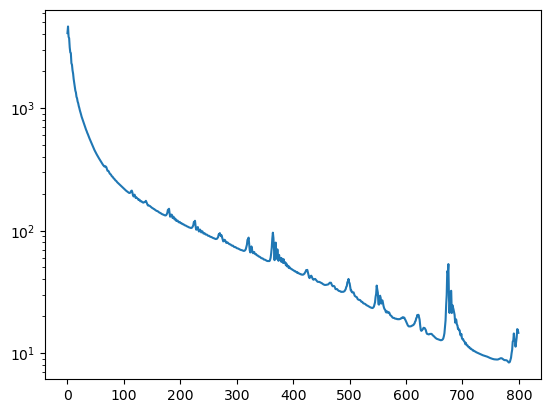

In [7]:
plt.semilogy(losses)

In [8]:
data = video.astype(np.float32)
data = list(DataLoader(dataset=data, batch_size=len(data), shuffle=False))[0]
output = model(data.to(device)).detach().cpu().numpy()

%matplotlib tk
animate_video(output)

# Perform frame interpolation in encoded space

In [9]:
encoded = model.encoder(data.to(device)).detach().cpu().numpy()
encoded_interpolated = interpolate_linear(np.arange(len(encoded)), np.arange(0, len(encoded), 0.1), encoded).astype(np.float32)
output_interpolated = model.decoder(torch.tensor(encoded_interpolated).to(device)).detach().cpu().numpy()

animate_video(output_interpolated)